In [1]:
import os, shutil

# 원본 데이터셋을 압축 해제한 디렉터리 경로
original_dataset_dir = './cats_and_dogs/train'

# 소규모 데이터셋을 저장할 디렉터리
base_dir = './cats_and_dogs_small'
if os.path.exists(base_dir):  # 반복적인 실행을 위해 디렉토리를 삭제합니다.
    shutil.rmtree(base_dir)   # 이 코드는 책에 포함되어 있지 않습니다.
os.mkdir(base_dir)

# 훈련, 검증, 테스트 분할을 위한 디렉터리
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

# 훈련용 고양이 사진 디렉터리
train_cats_dir = os.path.join(train_dir, 'cats')
os.mkdir(train_cats_dir)

# 훈련용 강아지 사진 디렉터리
train_dogs_dir = os.path.join(train_dir, 'dogs')
os.mkdir(train_dogs_dir)

# 검증용 고양이 사진 디렉터리
validation_cats_dir = os.path.join(validation_dir, 'cats')
os.mkdir(validation_cats_dir)

# 검증용 강아지 사진 디렉터리
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
os.mkdir(validation_dogs_dir)

# 테스트용 고양이 사진 디렉터리
test_cats_dir = os.path.join(test_dir, 'cats')
os.mkdir(test_cats_dir)

# 테스트용 강아지 사진 디렉터리
test_dogs_dir = os.path.join(test_dir, 'dogs')
os.mkdir(test_dogs_dir)

# 처음 1,000개의 고양이 이미지를 train_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# 다음 500개 고양이 이미지를 validation_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 고양이 이미지를 test_cats_dir에 복사합니다
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# 처음 1,000개의 강아지 이미지를 train_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 validation_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# 다음 500개 강아지 이미지를 test_dogs_dir에 복사합니다
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

In [2]:
import tensorflow as tf
import tensorflow.keras as keras

In [18]:
conv_base = keras.applications.VGG16(weights="imagenet",
                                     include_top=False,
                                     input_shape=(150, 150, 3))

In [4]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [5]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = './cats_and_dogs_small'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(150, 150),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # 제너레이터는 루프 안에서 무한하게 데이터를 만들어내므로 모든 이미지를 한 번씩 처리하고 나면 중지합니다
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [8]:
train_features.shape, train_features.min(), train_features.max()

((2000, 4, 4, 512), 0.0, 10.988971710205078)

In [9]:
# (20000, 4, 4, 512) -> (20000, 4*4*512)
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = \
    np.reshape(validation_features, (1000, 4 * 4 * 512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(256, 
                             input_shape=(4*4*512,), 
                             activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, 
                             activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
              metrics=['accuracy'])

history = model.fit(train_features, train_labels,
                    batch_size=20,
                    epochs=30,
                    validation_data=(validation_features,
                                     validation_labels))

Epoch 1/30
100/100 [==============================] - 3s 28ms/step - loss: 0.5769 - accuracy: 0.6865 - val_loss: 0.4522 - val_accuracy: 0.8350
Epoch 2/30
100/100 [==============================] - 2s 25ms/step - loss: 0.4297 - accuracy: 0.8040 - val_loss: 0.3659 - val_accuracy: 0.8670
Epoch 3/30
100/100 [==============================] - 3s 25ms/step - loss: 0.3540 - accuracy: 0.8560 - val_loss: 0.3246 - val_accuracy: 0.8790
Epoch 4/30
100/100 [==============================] - 2s 25ms/step - loss: 0.3068 - accuracy: 0.8765 - val_loss: 0.3052 - val_accuracy: 0.8820
Epoch 5/30
100/100 [==============================] - 2s 24ms/step - loss: 0.2905 - accuracy: 0.8795 - val_loss: 0.2855 - val_accuracy: 0.8930
Epoch 6/30
100/100 [==============================] - 2s 25ms/step - loss: 0.2647 - accuracy: 0.8970 - val_loss: 0.2945 - val_accuracy: 0.8770
Epoch 7/30
100/100 [==============================] - 3s 25ms/step - loss: 0.2515 - accuracy: 0.9045 - val_loss: 0.2656 - val_accuracy: 0.8940

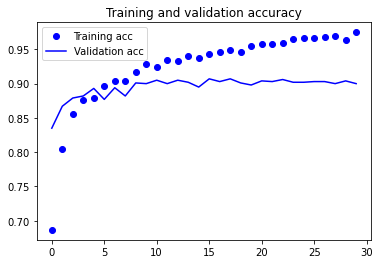

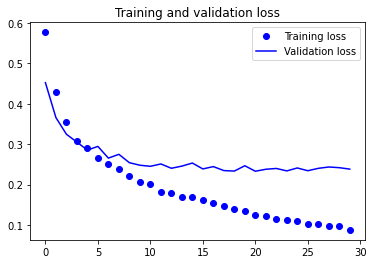

In [11]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

In [20]:
conv_base.trainable = False # 가중치 업데이트 금지

In [21]:
model2 = keras.models.Sequential()
model2.add(conv_base)
model2.add(keras.layers.Flatten())
model2.add(keras.layers.Dense(256, activation='relu'))
model2.add(keras.layers.Dropout(0.5))
model2.add(keras.layers.Dense(1, activation='sigmoid'))

In [22]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [23]:
len( model2.trainable_weights )

4

In [14]:
# 폴더에서 이미지 파일을 읽고 수치데이터로 인코딩해주는 도구
train_gen = \
    keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_gen = \
    keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(150, 150), # 모든 이미지의 크기를 150X150으로 변경
    batch_size=20, #  한 번에 읽을 이미지 개수
    class_mode='binary'
)
validation_generator = test_gen.flow_from_directory(
    validation_dir,
    target_size=(150, 150), # 모든 이미지의 크기를 150X150으로 변경
    batch_size=20, #  한 번에 읽을 이미지 개수
    class_mode='binary'
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [24]:
model2.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
               metrics=['accuracy'])

history = model2.fit(train_generator,
                     steps_per_epoch=100,
                     epochs=30,
                     validation_data=validation_generator,
                     validation_steps=50)

Epoch 1/30
100/100 [==============================] - 349s 3s/step - loss: 0.6183 - accuracy: 0.6575 - val_loss: 0.4508 - val_accuracy: 0.8190
Epoch 2/30
100/100 [==============================] - 356s 4s/step - loss: 0.4291 - accuracy: 0.8035 - val_loss: 0.3691 - val_accuracy: 0.8490
Epoch 3/30
100/100 [==============================] - 373s 4s/step - loss: 0.3559 - accuracy: 0.8505 - val_loss: 0.3315 - val_accuracy: 0.8640
Epoch 4/30
 89/100 [=========================>....] - ETA: 26s - loss: 0.3100 - accuracy: 0.8708

KeyboardInterrupt: 

In [25]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [33]:
conv_base.trainable = True

for layer in conv_base.layers:
    # print(layer.name, layer.trainable)
    if 'block5_c' in layer.name:
        layer.trainable = True
    else:
        layer.trainable = False

In [34]:
model2.compile(loss='binary_crossentropy',
               optimizer=keras.optimizers.RMSprop(learning_rate=2e-5),
               metrics=['accuracy'])

history = model2.fit(train_generator,
                     steps_per_epoch=100,
                     epochs=30,
                     validation_data=validation_generator,
                     validation_steps=50)

Epoch 1/30
100/100 [==============================] - 403s 4s/step - loss: 0.2498 - accuracy: 0.8980 - val_loss: 0.2250 - val_accuracy: 0.9030
Epoch 2/30
100/100 [==============================] - 408s 4s/step - loss: 0.1466 - accuracy: 0.9465 - val_loss: 0.1937 - val_accuracy: 0.9240
Epoch 3/30
100/100 [==============================] - 408s 4s/step - loss: 0.0912 - accuracy: 0.9640 - val_loss: 0.1943 - val_accuracy: 0.9190
Epoch 4/30
100/100 [==============================] - 407s 4s/step - loss: 0.0505 - accuracy: 0.9850 - val_loss: 0.2010 - val_accuracy: 0.9240
Epoch 5/30
100/100 [==============================] - 406s 4s/step - loss: 0.0267 - accuracy: 0.9930 - val_loss: 0.2905 - val_accuracy: 0.8910
Epoch 6/30
100/100 [==============================] - 407s 4s/step - loss: 0.0172 - accuracy: 0.9955 - val_loss: 0.2125 - val_accuracy: 0.9340
Epoch 7/30
100/100 [==============================] - 414s 4s/step - loss: 0.0152 - accuracy: 0.9935 - val_loss: 0.2501 - val_accuracy: 0.9290